### Torchvision Object Detection Finetuning Tutorial
* 본 튜토리얼에서는 Penn-Fudan Database for Pedestrian Detection and Segmentation 데이터셋으로 미리 학습된 Mask R-CNN 모델을 미세조정 해 볼 것임.
* 이 데이터셋에는 보행자 인스턴스(instance, 역자주 : 이미지 내에서 사람의 위치 좌표와 픽셀 단위의 사람 여부를 구분한 정보를 포함함.)
* 345명이 있는 170개의 이미지가 포함되어 있으며, 우리는 이 이미지를 사용하여 사용자 정의 데이터셋에 인스턴스 분할(Instance Segmentation) 모델을 학습하기 위해 torchvision의 새로운 기능을 사용하는 방법을 설명 할 예정임.

### Defining the Dataset
* 객체 검출, 인스턴스 분할 및 사용자 키포인트(Keypoint) 검출을 학습하기 위한 참조 스크립트를 통해 새로운 사용자 정의 데이터셋 추가를 쉽게 진행해 볼 수 있음.
* 데이터셋은 표준 torch.utils.data.Dataset 클래스를 상속 받아야 하며, \_\_len\_\_와 \_\_getitem\_\_ 메소드를 구현해 주어야 함.

* 데이터셋에서 필요한 유일한 특성은 \_\_getitem\_\_ 메소드가 다음을 반환 해야 하는 것.
    + 이미지 : PIL(Python Image Library) 이미지의 크기 (H, W)
    + 대상 : 다음의 필드를 포함하는 사전 타입
        - boxes (FloatTensor[N, 4]) : N 개의 바운딩 박스(Bounding box)의 좌표를 [x0, y0, x1, y1] 형태로 가짐.
        - x 와 관련된 값 범위는 0부터 W 이고 y 와 관련된 범위는 0부터 H 까지임.
        - labels (Int64Tensor[N]) : 바운딩 박스 마다의 라벨 정보.
        - 0은 항상 배경의 클래스를 표현.
        - image_id (Int64Tensor[1]) : 이미지 구분자.
        - 데이터셋의 모든 이미지 간에 고유한 값이어야 하며 평가 중에도 사용됨.
        - area (Tensor[N]) : 바운딩 박스의 면적.
        - 면적은 평가 시 작음, 중간, 큰 박스 간의 점수를 내기 위한 기준이며 COCO 평가를 기준으로 함.
        - iscrowd (UInt8Tensor[N]) : 이 값이 참일 경우 평가에서 제외함.
        - (선택적) masks (UInt8Tensor[N, H, W]) : N 개의 객체 마다의 분할 마스크 정보.
        - (선택적) keypoints (FloatTensor[N, K, 3]) : N 개의 객체마다의 키포인트 정보.
        - 키포인트는 [x, y, visibility] 형태의 값.
        - visibility 값이 0인 경우 키포인트는 보이지 않음을 의미함.
        - 데이터 증강(Data augmentation)의 경우 키포인트 좌우 반전의 개념은 데이터 표현에 따라 달라지며, 새로운 키포인트 표현에 대해 <<references/detection/transforms.py>> 코드 부분을 수정해야 할 수도 있음.

* 모델이 위의 방법대로 리턴을 하면, 학습과 평가 둘 다에 대해서 동작을 할 것이며 평가 스크립트는 pip install pycocotools 로 설치 가능한 pycocotools 를 사용하게 될 것.

* 참고
    + 윈도우즈에서는  pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI 명령어를 사용하여 pycocotools 를 gautamchitnis 로부터 가져와 설치함.

* labels 에 대한 참고사항.
* 이 모델은 클래스 0 을 배경으로 취급함.
* 만약 준비한 데이터셋에 배경의 클래스가 없다면, labels 에도 0 이 없어야 함.
* 예를 들어, 고양이와 강아지의 오직 2개의 클래스만 분류한다고 가정하면, (0 이 아닌) 1 이 고양이를, 2 가 강아지를 나타내도록 정의해야 함.
* 따라서, 이 예시에서, 어떤 이미지에 두 개의 클래스를 모두 있다면, labels 텐서는 [1, 2]와 같은 식이 되어야 함.

* 추가로, 학습 중에 가로 세로 비율 그룹화를 사용하려는 경우(각 배치에 유사한 가로 세로 비율이 있는 영상만 포함되도록),
* 이미지의 넓이, 높이를 리턴할 수 있도록 get_height_and_width 메소드를 구현하기를 추천함.
* 이 메소드가 구현되지 않은 경우에는 모든 데이터셋은 \_\_getitem\_\_ 를 통해 메모리에 이미지가 로드되며 사용자 정의 메소드를 제공하는 것보다 느릴 수 있음.

### Writing a custom dataset for PennFudan
* PennFudan 데이터셋을 위한 코드를 작성해 보겠음.
* `다운로드 후 압축 파일을 해제하면<https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip>`__, 다음의 폴더 구조

In [4]:
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
# cd data && unzip PennFudanPed.zip

PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png

* 한 쌍의 영상과 분할 마스크의 한 가지 예는 다음과 같음.

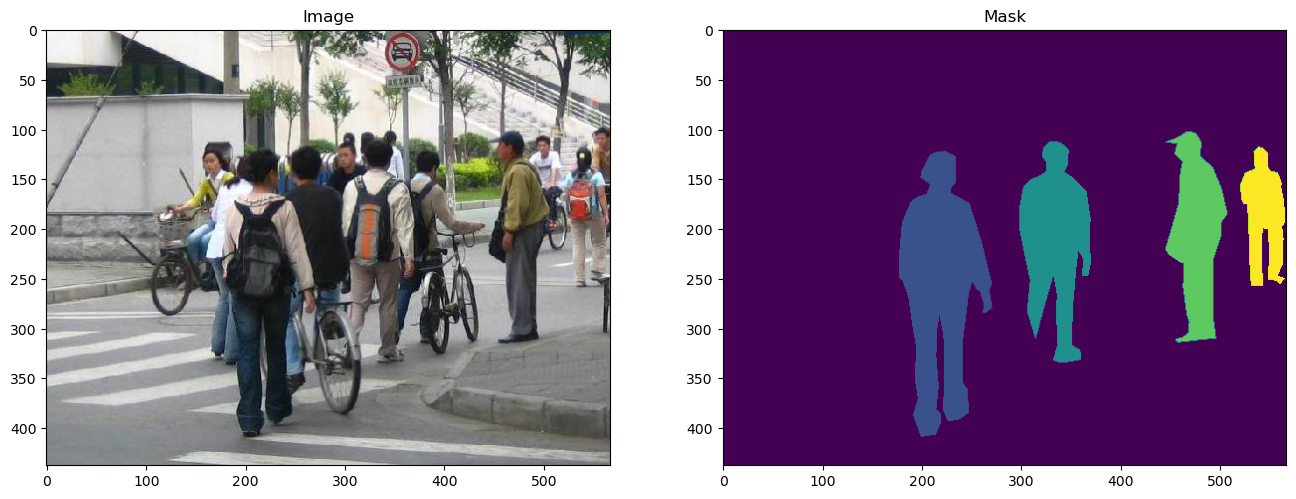

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

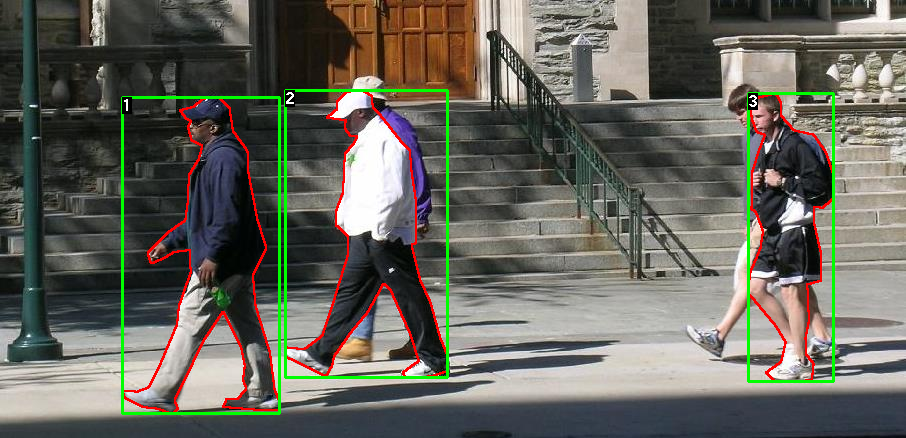

In [2]:
from IPython.display import Image

Image("https://tutorials.pytorch.kr/_static/img/tv_tutorial/tv_image01.png")

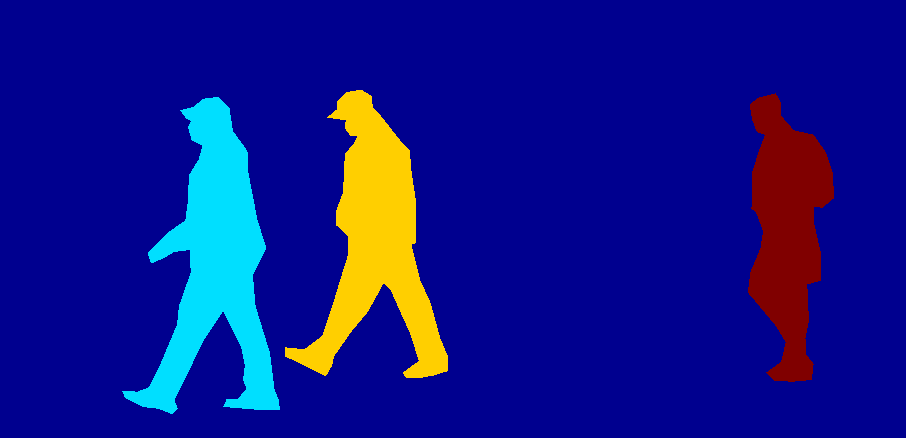

In [3]:
from IPython.display import Image

Image("https://tutorials.pytorch.kr/_static/img/tv_tutorial/tv_image02.png")

* 각 이미지에는 해당하는 분할 마스크가 있으며, 여기서 각각의 색상은 다른 인스턴스에 해당함.
* 데이터셋에 해당하는 torch.utils.data.Dataset 클래스르 작성해봄.

In [4]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # 모든 이미지 파일들을 읽고, 정렬하여
        # 이미지와 분할 마스크 정렬을 확인
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 이미지와 마스크를 읽어옵니다
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # 분할 마스크는 RGB로 변환하지 않음을 유의
        # 왜냐하면 각 색상은 다른 인스턴스에 해당하며, 0은 배경에 해당
        mask = Image.open(mask_path)
        # numpy 배열을 PIL 이미지로 변환
        mask = np.array(mask)
        # 인스턴스들은 다른 색들로 인코딩
        obj_ids = np.unique(mask)
        # 첫번째 id 는 배경이라 제거
        obj_ids = obj_ids[1:]

        # 컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눔
        masks = mask == obj_ids[:, None, None]

        # 각 마스크의 바운딩 박스 좌표를 얻음
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 모든 것을 torch.Tensor 타입으로 변환합니다
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # 객체 종류는 한 종류만 존재합니다(역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

* 데이터셋 코드는 여기까지임.
* 이제 이 데이터셋에 대한 예측을 수행할 수 있는 모델을 정의해봄.

### Defining your model
* 이번 튜토리얼에서는 Faster R-CNN 에 기반한 Mask R-CNN 모델을 사용할 예정임.
* Faster R-CNN은 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델임.

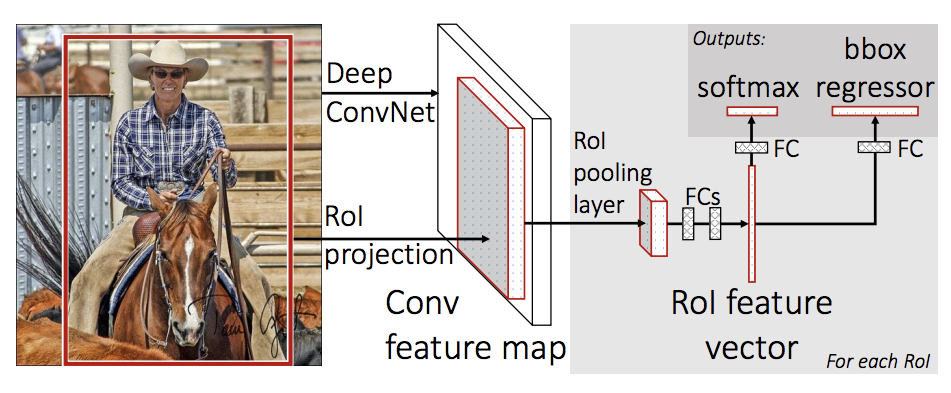

In [5]:
from IPython.display import Image

Image("https://tutorials.pytorch.kr/_static/img/tv_tutorial/tv_image03.png")

* Mask R-CNN은 각 인스턴스에 대한 분할 마스크 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델임.

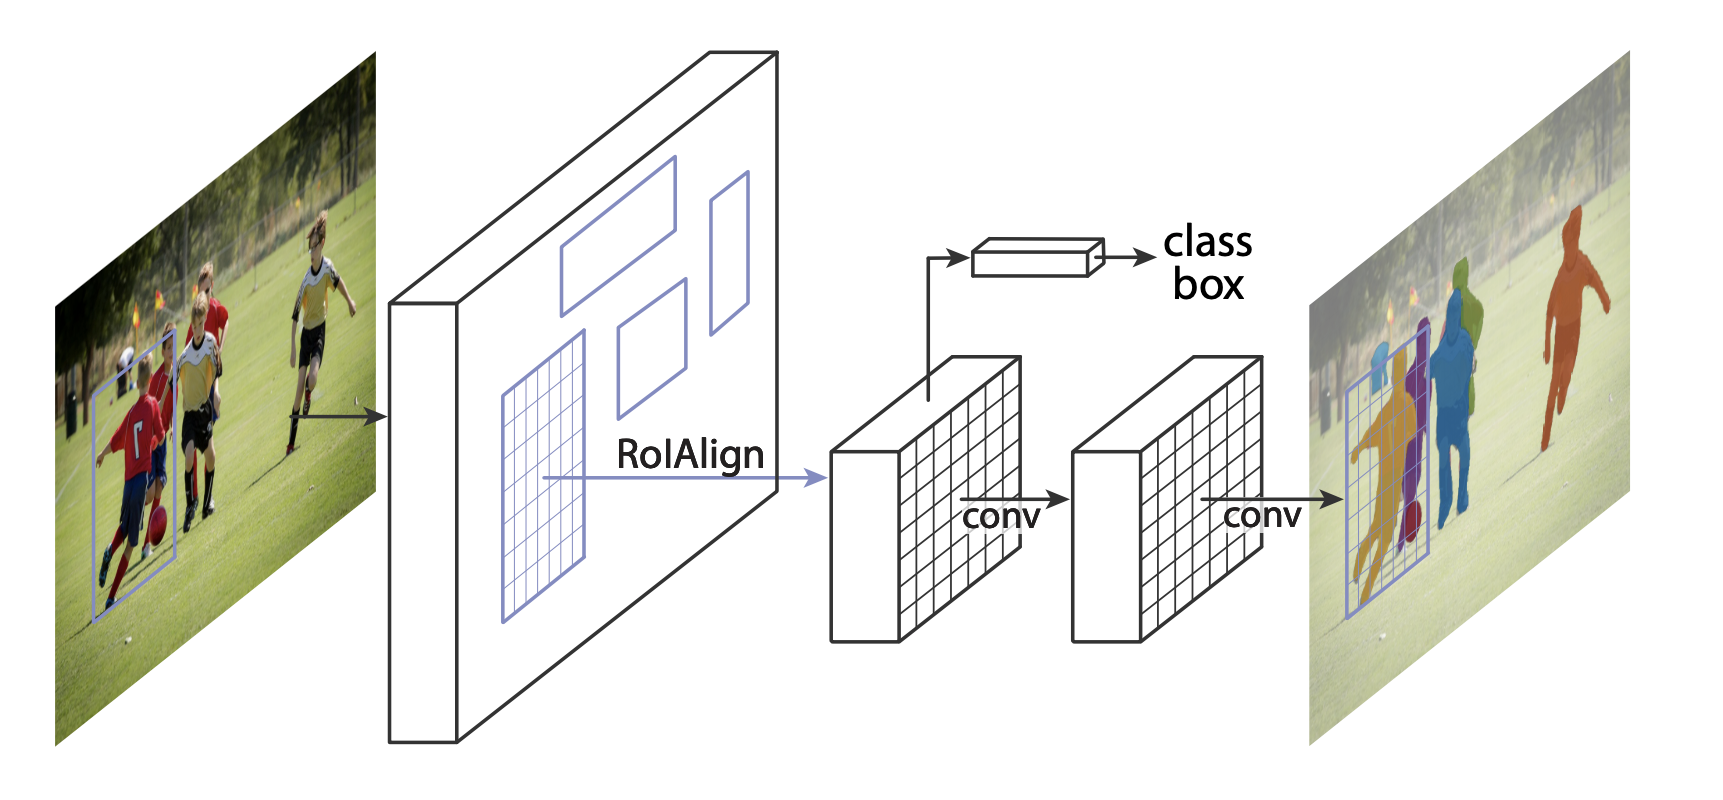

In [6]:
from IPython.display import Image

Image("https://tutorials.pytorch.kr/_static/img/tv_tutorial/tv_image04.png")

* Torchvision 모델주(model zoo, 역자주: 미리 학습된 모델들을 모아 놓은 공간)에서 사용 가능한 모델들 중 하나를 이용해 모델을 수정하려면 보통 두 가지 상황이 있음.
* 첫 번째 방법은 미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 것.
* 다른 하나는 모델의 백본을 다른 백본으로 교체하는 것임.
* (예를 들면, 더 빠른 예측을 하려고 할때) (역자주:백본 모델을 ResNet101에서 MobilenetV2 로 교체하면 수행 속도 향상을 기대할 수 있음. 대신 인식 성능은 저하 될 수 있음.)

* 다음 섹션에서 우리가 어떻게 할 수 있는지 알아봄.

### 1. Finetuning from a pretrained model
* COCO에 대해 미리 학습된 모델에서 시작하여 특정 클래스를 위해 미세 조정을 원한다고 가정해봄.
* 아래와 같은 방법으로 가능함.

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCO로 미리 학습된 모델 읽기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의
num_classes = 2  # 1 클래스(사람) + 배경
# 분류기에서 사용할 입력 특징의 차원 정보를 얻음
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2. Modifying the model to add a different backbone

In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 분류 목적으로 미리 학습된 모델을 로드하고 특징들만을 리턴
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# Faster RCNN은 백본의 출력 채널 수를 알아야 합니다.
# mobilenetV2의 경우 1280이므로 여기에 추가해야 함
backbone.out_channels = 1280

# RPN(Region Proposal Network)이 5개의 서로 다른 크기와 3개의 다른 측면 비율(Aspect ratio)을 가진
# 5 x 3개의 앵커를 공간 위치마다 생성
# 각 특징 맵이 잠재적으로 다른 사이즈와 측면 비율을 가질 수 있기 때문에 Tuple[Tuple[int]] 타입을 가지도록 함

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# 관심 영역의 자르기 및 재할당 후 자르기 크기를 수행하는 데 사용할 피쳐 맵을 정의
# 만약 백본이 텐서를 리턴할때, featmap_names 는 [0] 이 될 것이라고 예상
# 일반적으로 백본은 OrderedDict[Tensor] 타입을 리턴
# 그리고 특징맵에서 사용할 featmap_names 값을 정할 수 있음
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# 조각들을 Faster RCNN 모델로 합침
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

### Object detection and instance segmentation model for PennFudan Dataset
* 데이터 세트가 매우 작기 때문에, 우리는 1번 접근법을 따를 것이라는 점을 고려하여 미리 학습된 모델에서 미세 조정하는 방식으로 진행함.

* 여기서 인스턴스 분할 마스크도 계산하기를 원하기 때문에  Mask R-CNN를 사용함.

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # COCO 에서 미리 학습된 인스턴스 분할 모델을 읽어옴
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # 분류를 위한 입력 특징 차원을 얻음
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 미리 학습된 헤더를 새로운 것으로 바꿈
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기를 위한 입력 특징들의 차원을 얻음
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # 마스크 예측기를 새로운 것으로 바꿈
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

* 이렇게 하면 모델을 사용자 정의 데이터셋에서 학습하고 평가할 준비가 될 것.

### Putting everything together

* references/detection/ 폴더 내에 검출 모델들의 학습과 평가를 쉽게 하기 위한 도움 함수들이 있음.
* 여기서 references/detection/engine.py, references/detection/utils.py, references/detection/transforms.py 를 사용 할 것.
* references/detection 아래의 모든 파일과 폴더들을 사용자의 폴더로 복사한 뒤 사용.

In [10]:
import os

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

1

* 데이터 증강 / 변환을 위한 도움 함수를 작성해 봄.

In [11]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float, scale = True))
    if train:
        # (역자주: 학습시 50% 확률로 학습 영상을 좌우 반전 변환)
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Testing forward() method (Optional)
* 데이터셋을 반복하기 전에, 샘플 데이터로 학습과 추론 시 모델이 예상대로 동작하는지 살펴보는 것이 좋음.

In [ ]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# 학습 시
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# 추론 시
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

In [17]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # 학습을 GPU로 진행하되 GPU가 가용하지 않으면 CPU로 합니다
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # 우리 데이터셋은 두 개의 클래스만 가집니다 - 배경과 사람
    num_classes = 2
    # 데이터셋과 정의된 변환들을 사용합니다
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # 데이터셋을 학습용과 테스트용으로 나눕니다(역자주: 여기서는 전체의 50개를 테스트에, 나머지를 학습에 사용합니다)
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # 데이터 로더를 학습용과 검증용으로 정의합니다
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # 도움 함수를 이용해 모델을 가져옵니다
    model = get_model_instance_segmentation(num_classes)

    # 모델을 GPU나 CPU로 옮깁니다
    model.to(device)

    # 옵티마이저(Optimizer)를 만듭니다
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # 학습률 스케쥴러를 만듭니다
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # 10 에포크만큼 학습해봅시다
    num_epochs = 10

    for epoch in range(num_epochs):
        # 1 에포크동안 학습하고, 10회 마다 출력합니다
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # 학습률을 업데이트 합니다
        lr_scheduler.step()
        # 테스트 데이터셋에서 평가를 합니다
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

main()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\lab/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

RuntimeError: DataLoader worker (pid(s) 2876, 12468, 23328, 6480) exited unexpectedly